In [1]:
# util for SFG DRO
import torch
from sklearn.kernel_approximation import RBFSampler
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from torch.optim.swa_utils import AveragedModel  # average model weights
import torch.optim as optim



class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

# This function builds the model for one-vs-all classification
def buildModel(task=None, method=None,n_hidden=100, device=None, loss_reduction='mean'):
    n_output = 1  # Only one output node for one-vs-all classification
    loss_erm = nn.BCEWithLogitsLoss(reduction=loss_reduction)  # Binary Cross-Entropy Loss
    
    # Defining the model architecture
    modelDecision = nn.Sequential(
        Flatten(), 
        nn.Linear(784, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_output)
    ).to(device)
    
    return modelDecision, loss_erm

def computeErr(yp, y,task=None,shuffle_test=False):
    predictions = (yp > 0).float()  # Converting model outputs to binary predictions
    err = (predictions != y).float().mean().item()  # Calculating the error rate
    return err





In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def cifar10Data(task='one_vs_all', class_num=0, batch_size=100, shuffle_test=False):
    if class_num < 0 or class_num > 9:
        raise ValueError("class_num should be between 0 and 9")

    # Applying necessary transforms on the CIFAR-10 data including grayscale and resize
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    # Fetching CIFAR-10 data
    cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    
    if task == 'binary':
        train_idx = np.where((np.array(cifar10_train.targets) == 0) | (np.array(cifar10_train.targets) == 1))
        cifar10_train.targets = np.array(cifar10_train.targets)[train_idx]
        cifar10_train.data = cifar10_train.data[train_idx]

        test_idx = np.where((np.array(cifar10_test.targets) == 0) | (np.array(cifar10_test.targets) == 1))
        cifar10_test.targets = np.array(cifar10_test.targets)[test_idx]
        cifar10_test.data = cifar10_test.data[test_idx]
    elif task == 'one_vs_all':
        cifar10_train.targets = (np.array(cifar10_train.targets) == class_num).astype(float)
        cifar10_test.targets = (np.array(cifar10_test.targets) == class_num).astype(float)
    elif task == 'multi':
        # For multi-class classification, no need to modify the labels
        pass
    else:
        raise NotImplementedError

    train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=shuffle_test)

    return train_loader, test_loader




In [4]:
# for torch autograd
def apply_gd(x, step_gamma=0.1):
    xnew = x - step_gamma * x.grad.detach()
    x.grad.data.zero_()
    return xnew

# a general loss function
def loss_general_se(output, target):
    return torch.sum((output - target) ** 2, dim=1).reshape(-1, 1)


def sample_zeta(X, y, zeta_sample_method=None, loss_erm=None, modelDecision=None, n_sample_zeta=1, epsilon_attack=0.0, learn_task=None, F=None):
    Z = None
    yperturb = None

    for _ in range(n_sample_zeta):
        delta = zeta_sample_method(loss_erm, modelDecision, X, y, randomize=True, epsilon=epsilon_attack,
                                   alpha=0.01, num_iter=20, task=learn_task, rkhsF=F)  # used with the new pgd
        # delta = attack(loss_erm, modelDecision, X, y, randomize=True, epsilon=1.0, alpha=0.01, num_iter=20, task=learn_task, rkhsF=F) # used with the new pgd

        Zperturb = X + delta
        if Z is not None:  # also penalize the original loss at unperturbed data
            Z = torch.cat((Zperturb, Z))  # cat new perturb Z with the old
            yperturb = torch.cat((yperturb, y))
        else:
            Z = Zperturb
            yperturb = y

    return Z, yperturb

In [5]:
def sfg_train_step(X=None, y=None, just_rand=None, loss_erm=None, modelDecision=None, n_sample_zeta=None, epsilon_attack=None,
                   learn_task=None, F=None, epsilon=None, stat_plot=None, i_decay_csa=None, is_step_const=None,
                   model_class=None, modelSWA=None):
    Z, y = sample_zeta(X, y, zeta_sample_method=just_rand, loss_erm=loss_erm,
                       modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                       epsilon_attack=epsilon_attack, learn_task=learn_task, F=F)
    yp = evalutateErmModel(modelDecision, Z,
                           task=learn_task)  # use original model in ERM to run thru data X
    # kdro surrogate loss
    f_emp = torch.mean(F(X, fit=True))  # emp loss under emp loss
    # '''KDRO obj'''
    obj = f_emp + epsilon * F.norm()  # obj of the optimization problem
    #  original loss l eval on z
    loss_emp = loss_erm(yp, y).reshape(-1, 1)
    assert loss_emp.shape == F(Z).shape
    cons_sip = loss_emp - F(Z)  # constraint function of SIP. G(th, zeta)
    partial_moment = 1
    if partial_moment:  # use functional constr: E h(l-f) = 0
        max_cons_g = torch.mean(torch.nn.functional.relu(cons_sip))
    else:
        max_cons_g, id_max = torch.max(cons_sip, 0)  # max of violation across all samples zeta
    # bookeeping
    stat_plot["max_cons_violation"].append(max_cons_g.data.detach())
    stat_plot["obj"].append(obj.data.detach())

    '''CSA - SGD step size'''
    # threshold
    threshold_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    # threshold_csa = 0.01 # constant step
    # step size
    if is_step_const:
        step_csa = 0.01
    else:
        step_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    i_decay_csa += 1
    # %% update dec var: th, f0, f
    # zero gradient before backward
    try:
        for w in modelDecision.parameters(): w.grad.data.zero_()
        for w in F.model.parameters(): w.grad.data.zero_()
    except:
        pass
    if max_cons_g <= threshold_csa:  # if constr satisfied
        obj.backward()
        # there is no th update since obj doens't have th in it

        # %% if cons. satisfied, polyak averaging to keep track of average
        if model_class == 'mlp':
            modelSWA.update_parameters(modelDecision)  # model with averaged weights
            # pass
        else:
            raise NotImplementedError

    else:  # cons violation
        if partial_moment:
            max_cons_g.backward()  # diff this:  E h(l-f)
        else:
            cons_sip[id_max].backward()

        # update model var
        if model_class == 'mlp':
            for weight in modelDecision.parameters():
                weight.data = apply_gd(weight, step_csa)
        else:
            raise NotImplementedError
    # update f0, weights of f
    for weight in F.model.parameters():
        weight.data = apply_gd(weight, step_csa)
    return i_decay_csa, stat_plot


In [6]:
def run_test(test_loader, modelERM, loss_erm, loaded, attack_function=None, attack_range=None, task=None, n_test=100, device=None):
    D = {'err': [], 'attack': [], 'sig': []}
    for attack_strength in attack_range:
        i_test = 0

        err_this_attack = []
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            if task=='binary' or task=='one_vs_all':
                y = y.float()
            i_test += 1
            if i_test > n_test:
                break

            delta = attack_function(loss_erm, modelERM, X, y, attack_strength, task=task)

            # evaluate attack
            #         plt.figure()
            yp = evalutateErmModel(loaded['model'], X + delta, task=task)
            err_kdro = computeErr(yp, y, task=task)

            err_this_attack.append(deepcopy(err_kdro))

        # for each attack, compute average
        D['err'].append(np.mean(err_this_attack))
        D['sig'].append(np.std(err_this_attack))
        D['attack'].append(attack_strength)

    D['n_run'] = len(err_this_attack)  # total number of runs
    D['eps_dro'] = loaded['epsilon']
    D['is_erm'] = loaded['is_erm']
    try:
        D['is_pgd'] = loaded['is_pgd']
    except:
        pass

    D['task'] = task

    return D



In [7]:
class RKHSfunction():
    # easier to use with random features
    def __init__(self, kernel_gamma, seed=1, n_feat = 96):
        self.kernel_gamma = kernel_gamma
        self.n_feat = n_feat
        self.model = nn.Sequential(Flatten(), nn.Linear(n_feat, 1, bias=True)) # random feature. the param of this models are the weights, i.e., decision var
        self.seed = seed
        self.rbf_feature = RBFSampler(gamma=kernel_gamma, n_components=n_feat, random_state=seed) # only support Gaussian RKHS for now
        # self.rbf_feature.fit(X_example.view(X_example.shape[0], -1))

    def eval(self, X, fit=False):
        x_reshaped = (X.view(X.shape[0], -1))

        if fit:
            self.rbf_feature.fit(x_reshaped) # only transform during evaluation

        if not x_reshaped.requires_grad:
            # x_feat = self.rbf_feature.fit_transform(x_reshaped)
            x_feat = self.rbf_feature.transform(x_reshaped) # only transform during evaluation
            rkhsF = self.model(torch.from_numpy(x_feat).float())
        else:
            # raise NotImplementedError
            # print('need a pth impl of fit transform')
            # internally: self.fit(X, **fit_params).transform(X)
            x_detach = x_reshaped.detach()
            x_fitted = self.rbf_feature.fit(x_detach, y=None)
            # x_fitted.transform(x_reshaped)
            x_feat = pth_transform(x_fitted, x_reshaped)
            # assert torch.max(x_feat.detach() - self.rbf_feature.fit_transform(x_detach)) == 0 # there's randomness of course
            rkhsF = self.model(x_feat)[:, 0]

        return rkhsF

    def norm(self):
        return computeRKHSNorm(self.model)

    def set_seed(self,seed):
        # set the seed of RF. such as in doubly SGD
        self.seed = seed
        self.rbf_feature = RBFSampler(gamma=self.kernel_gamma, n_components=self.n_feat, random_state=seed) # only support Gaussian RKHS for now

    def __call__(self, X, fit=False, random_state=False):
        if random_state is True:
            self.set_seed(seed=np.random) # do a random seed reset for doubly stochastic
        # else:
        #     self.set_seed(seed=1)
        return self.eval(X, fit)


In [8]:

def evalutateErmModel(modelDecision, X, task=None):
    yp = modelDecision(X.view(X.shape[0], -1)).squeeze()  # No need for indexing in one-vs-all
    return yp


def computeRKHSNorm(modelRF, no_bias = True):
    if no_bias: # do no penalize the constant in the RKHS norm (random feature, f:= f0 + w*phi, only regularize w*w)
        hnorm = torch.norm([w for w in modelRF.parameters()][
                              0])  # rkhs norm is just 2norm of weights of random features; index[0] because we don't need to consider reg of the constant f0
    else:
        hnorm = torch.norm([w for w in modelRF.parameters()][0]) +  torch.norm([w for w in modelRF.parameters()][0])

    return hnorm




def median_heuristic(X, Y):
    '''
    the famous kernel median heuristic
    '''
    distsqr = euclidean_distances(X, Y, squared=True)
    kernel_width = np.sqrt(0.5 * np.median(distsqr))

    '''in sklearn, kernel is done by K(x, y) = exp(-gamma ||x-y||^2)'''
    kernel_gamma = 1.0 / (2 * kernel_width ** 2)

    return kernel_width, kernel_gamma



In [9]:
def pgd_linf(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None):
    """ Construct PGD adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = loss_attack(evalutateErmModel( model, X + delta, task=task), y)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()

    # for w in model.parameters(): w.grad.data.zero_()
        # for w in rkhsF.model.parameters(): w.grad.data.zero_()
    return delta.detach()


def just_rand(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None, **kwargs):
    """ just use random noises to sample new samples"""
    delta = torch.rand_like(X, requires_grad=False)
    delta.data = 2* (delta.data - 0.5) * epsilon

    return delta.detach()

In [10]:
# params
n_epoch_gd = 10 # how many epochs of SFG to run
learn_task = 'one_vs_all'
mini_batch = 20 
model_class = 'mlp'
loss_reduction = 'none'
n_rand_feat = 500
n_sample_zeta = 150
epsilon_attack = 0.5  # largest perturbation of the domain allowed in RO
epsilon = 1.0  # Kernel DRO ambiguity size
is_step_const = 0  # use decay step size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set up
train_loader, test_loader = cifar10Data(task=learn_task, batch_size=mini_batch)
modelDecision, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device,
                                     loss_reduction=loss_reduction)
modelSWA = AveragedModel(modelDecision)  # model with averaged weights

# example test data
X_example = (torch.tensor(test_loader.dataset.data).float() / 255).reshape(len(test_loader.dataset), -1)
y_example = test_loader.dataset.targets

# dual var f: RKHS function
_, kernel_gamma = median_heuristic(X_example, X_example)  # median heuristic
F = RKHSfunction(kernel_gamma * 2, n_feat=n_rand_feat)  # rkhs function using random features

# bookkeeping dict
stat_plot = {"max_cons_violation": [], "obj": []}

Files already downloaded and verified
Files already downloaded and verified


In [11]:
from tqdm import tqdm

print("=========Training SFG DRO=========")

i_decay_csa = 0  # counter for threshold decay

# Wrapping the range function with tqdm to get progress bar for epochs
for i_epoch in tqdm(range(n_epoch_gd), desc="Epochs"):
    # Wrapping the train_loader with tqdm to get progress bar for batches
    for X, y in tqdm(train_loader, desc="Batches", leave=False):
        X, y = X.to(device), y.to(device)
        if learn_task=='binary' or learn_task=='one_vs_all':
            y = y.float()

        i_decay_csa, stat_plot = sfg_train_step(X=X, y=y, just_rand=just_rand, loss_erm=loss_erm,
                                                modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                                                epsilon_attack=epsilon_attack,
                                                learn_task=learn_task, F=F, epsilon=epsilon, stat_plot=stat_plot,
                                                i_decay_csa=i_decay_csa,
                                                is_step_const=is_step_const,
                                                model_class=model_class, modelSWA=modelSWA)
    print('epoch:', i_epoch, '/', n_epoch_gd)

print("=========Training Finished=========")

=========Training SFG DRO=========


Batches:   5%|▌         | 126/2500 [08:37<2:30:56,  3.81s/it]


Batches:  10%|█         | 252/2500 [17:32<2:48:14,  4.49s/it]


Batches:  15%|█▌        | 378/2500 [26:09<2:30:46,  4.26s/it]


Batches:  20%|██        | 504/2500 [34:31<2:13:36,  4.02s/it]


Batches:  25%|██▌       | 630/2500 [43:12<1:58:52,  3.81s/it]


Batches:  30%|███       | 756/2500 [51:51<2:07:41,  4.39s/it]


Batches:  35%|███▌      | 881/2500 [1:00:02<1:37:48,  3.62s/it]


Batches:  40%|████      | 1003/2500 [1:08:11<1:41:47,  4.08s/it]


Batches:  45%|████▍     | 1123/2500 [1:16:03<1:26:02,  3.75s/it]


Batches:  50%|████▉     | 1243/2500 [1:23:57<1:20:12,  3.83s/it]


Batches:  55%|█████▍    | 1363/2500 [1:31:48<1:12:30,  3.83s/it]


Batches:  59%|█████▉    | 1483/2500 [1:39:45<1:07:44,  4.00s/it]


Batches:  64%|██████▍   | 1604/2500 [1:47:38<1:00:30,  4.05s/it]


Batches:  69%|██████▉   | 1727/2500 [1:55:52<49:40,  3.86s/it]


Batches:  74%|███████▍  | 1851/2500 [2:04:04<41:42,  3.86s/it]


Batches:  79%|███████▉  | 1975/2500 [2:12:10<39:51,  4.56s/it]


Batches:  84%|████████▍ | 2099/2500 [2:20:19<27:36,  4.13s/it]


Batches:  89%|████████▉ | 2223/2500 [2:28:31<19:30,  4.22s/it]


Batches:  94%|█████████▍| 2347/2500 [2:36:41<09:28,  3.72s/it]


Batches:  99%|█████████▉| 2471/2500 [2:44:51<01:48,  3.73s/it]


Epochs:  10%|█         | 1/10 [2:46:47<25:01:03, 10007.09s/it]

epoch: 0 / 10



Batches:   5%|▌         | 126/2500 [08:20<2:28:24,  3.75s/it]


Batches:  10%|█         | 252/2500 [16:30<2:24:45,  3.86s/it]


Batches:  15%|█▌        | 378/2500 [24:48<2:09:40,  3.67s/it]


Batches:  20%|██        | 504/2500 [33:06<2:07:02,  3.82s/it]


Batches:  25%|██▌       | 630/2500 [41:21<2:16:05,  4.37s/it]


Batches:  30%|███       | 756/2500 [49:37<1:49:46,  3.78s/it]


Batches:  35%|███▌      | 882/2500 [57:52<1:40:07,  3.71s/it]


Batches:  40%|████      | 1005/2500 [1:06:05<1:29:24,  3.59s/it]


Batches:  45%|████▌     | 1125/2500 [1:14:00<1:20:38,  3.52s/it]


Batches:  50%|████▉     | 1245/2500 [1:21:58<1:23:20,  3.98s/it]


Batches:  55%|█████▍    | 1365/2500 [1:29:52<1:20:25,  4.25s/it]


Batches:  59%|█████▉    | 1485/2500 [1:37:43<1:04:37,  3.82s/it]


Batches:  64%|██████▍   | 1606/2500 [1:45:48<55:37,  3.73s/it]


Batches:  69%|██████▉   | 1729/2500 [1:53:53<46:10,  3.59s/it]


Batches:  74%|███████▍  | 1853/2500 [2:02:13<46:01,  4.27s/it]


Batches:  79%|███████▉  | 1977/2500 [2:10:30<35:24,  4.06s/it]


Batches:  84%|████████▍ | 2101/2500 [2:18:46<27:13,  4.09s/it]


Batches:  89%|████████▉ | 2225/2500 [2:27:04<17:50,  3.89s/it]


Batches:  94%|█████████▍| 2349/2500 [2:35:26<10:38,  4.23s/it]


Batches:  99%|█████████▉| 2473/2500 [2:43:49<01:40,  3.71s/it]


Epochs:  20%|██        | 2/10 [5:32:26<22:08:56, 9967.05s/it] 

epoch: 1 / 10



Batches:   5%|▌         | 126/2500 [08:21<2:18:41,  3.51s/it]


Batches:  10%|█         | 252/2500 [16:43<2:28:24,  3.96s/it]


Batches:  15%|█▌        | 378/2500 [25:13<2:31:35,  4.29s/it]


Batches:  20%|██        | 504/2500 [33:32<2:12:41,  3.99s/it]


Batches:  25%|██▌       | 630/2500 [41:45<1:55:55,  3.72s/it]


Batches:  30%|███       | 756/2500 [50:10<2:00:31,  4.15s/it]


Batches:  35%|███▌      | 882/2500 [58:32<1:38:28,  3.65s/it]


Batches:  40%|████      | 1004/2500 [1:06:45<1:38:49,  3.96s/it]


Batches:  45%|████▍     | 1124/2500 [1:14:56<1:40:54,  4.40s/it]


Batches:  50%|████▉     | 1244/2500 [1:23:08<1:23:38,  4.00s/it]


Batches:  55%|█████▍    | 1364/2500 [1:31:16<1:13:46,  3.90s/it]


Batches:  59%|█████▉    | 1484/2500 [1:39:30<1:08:48,  4.06s/it]


Batches:  64%|██████▍   | 1604/2500 [1:48:20<1:05:16,  4.37s/it]


Batches:  69%|██████▉   | 1726/2500 [1:56:46<51:53,  4.02s/it]


Batches:  74%|███████▍  | 1850/2500 [2:05:27<45:00,  4.15s/it]


Batches:  79%|███████▉  | 1974/2500 [2:13:58<31:32,  3.60s/it]


Batches:  84%|████████▍ | 2098/2500 [2:22:30<25:15,  3.77s/it]


Batches:  89%|████████▉ | 2222/2500 [2:31:03<19:12,  4.14s/it]


Batches:  94%|█████████▍| 2346/2500 [2:39:33<09:49,  3.83s/it]


Batches:  99%|█████████▉| 2470/2500 [2:48:14<02:00,  4.02s/it]


Epochs:  30%|███       | 3/10 [8:22:45<19:36:15, 10082.28s/it]

epoch: 2 / 10



Batches:   5%|▌         | 126/2500 [08:49<2:34:44,  3.91s/it]


Batches:  10%|█         | 252/2500 [17:39<2:31:16,  4.04s/it]


Batches:  15%|█▌        | 378/2500 [26:37<2:41:18,  4.56s/it]


Batches:  20%|██        | 504/2500 [35:34<2:11:21,  3.95s/it]


Batches:  25%|██▌       | 630/2500 [44:14<1:59:35,  3.84s/it]


Batches:  30%|███       | 756/2500 [52:50<1:57:19,  4.04s/it]


Batches:  35%|███▌      | 881/2500 [1:01:24<1:55:53,  4.29s/it]


Batches:  40%|████      | 1003/2500 [1:09:47<1:56:52,  4.68s/it]


Batches:  45%|████▍     | 1123/2500 [1:18:00<1:38:15,  4.28s/it]


Batches:  50%|████▉     | 1243/2500 [1:26:10<1:21:00,  3.87s/it]


Batches:  55%|█████▍    | 1363/2500 [1:34:08<1:08:41,  3.62s/it]


Batches:  59%|█████▉    | 1483/2500 [1:42:17<1:03:13,  3.73s/it]


Batches:  64%|██████▍   | 1603/2500 [1:50:25<1:04:22,  4.31s/it]


Batches:  69%|██████▉   | 1726/2500 [1:58:46<54:27,  4.22s/it]  


Batches:  74%|███████▍  | 1850/2500 [2:07:06<46:05,  4.25s/it]


Batches:  79%|███████▉  | 1974/2500 [2:15:23<31:40,  3.61s/it]


Batches:  84%|████████▍ | 2098/2500 [2:23:44<25:03,  3.74s/it]


Batches:  89%|████████▉ | 2222/2500 [2:33:25<26:06,  5.63s/it]


Batches:  94%|█████████▍| 2346/2500 [2:43:17<11:25,  4.45s/it]


Batches:  99%|█████████▉| 2470/2500 [2:51:51<02:03,  4.12s/it]


Epochs:  40%|████      | 4/10 [11:16:38<17:02:05, 10220.86s/it][A

epoch: 3 / 10



Batches:   5%|▌         | 126/2500 [08:46<2:39:46,  4.04s/it]


Batches:  10%|█         | 252/2500 [17:24<2:41:08,  4.30s/it]


Batches:  15%|█▌        | 378/2500 [26:08<2:13:59,  3.79s/it]


Batches:  20%|██        | 504/2500 [34:54<2:31:19,  4.55s/it]


Batches:  25%|██▌       | 630/2500 [43:26<2:23:07,  4.59s/it]


Batches:  30%|███       | 756/2500 [51:59<1:45:08,  3.62s/it]


Batches:  35%|███▌      | 881/2500 [1:00:29<1:46:38,  3.95s/it]


Batches:  40%|████      | 1003/2500 [1:08:40<1:39:01,  3.97s/it]


Batches:  45%|████▍     | 1123/2500 [1:16:46<1:41:05,  4.41s/it]


Batches:  50%|████▉     | 1243/2500 [1:24:49<1:29:55,  4.29s/it]


Batches:  55%|█████▍    | 1363/2500 [1:32:46<1:15:14,  3.97s/it]


Batches:  59%|█████▉    | 1483/2500 [1:40:42<1:09:11,  4.08s/it]


Batches:  64%|██████▍   | 1604/2500 [1:48:43<58:29,  3.92s/it]


Batches:  69%|██████▉   | 1727/2500 [1:56:47<56:16,  4.37s/it]


Batches:  74%|███████▍  | 1851/2500 [2:05:10<49:09,  4.54s/it]


Batches:  79%|███████▉  | 1975/2500 [2:13:36<40:19,  4.61s/it]


Batches:  84%|████████▍ | 2099/2500 [2:22:00<28:08,  4.21s/it]


Batches:  89%|████████▉ | 2223/2500 [2:30:20<19:20,  4.19s/it]


Batches:  94%|█████████▍| 2347/2500 [2:38:43<09:12,  3.61s/it]


Batches:  99%|█████████▉| 2471/2500 [2:47:06<01:48,  3.73s/it]


Epochs:  50%|█████     | 5/10 [14:05:42<14:09:24, 10193.00s/it][A

epoch: 4 / 10



Batches:   5%|▌         | 126/2500 [08:26<2:38:41,  4.01s/it]


Batches:  10%|█         | 252/2500 [16:59<2:27:15,  3.93s/it]


Batches:  15%|█▌        | 378/2500 [25:27<2:21:02,  3.99s/it]


Batches:  20%|██        | 504/2500 [33:46<1:58:45,  3.57s/it]


Batches:  25%|██▌       | 630/2500 [42:12<1:52:33,  3.61s/it]


Batches:  30%|███       | 756/2500 [50:37<2:10:33,  4.49s/it]


Batches:  35%|███▌      | 882/2500 [59:05<2:02:24,  4.54s/it]


Batches:  40%|████      | 1004/2500 [1:07:19<1:34:25,  3.79s/it]


Batches:  45%|████▍     | 1124/2500 [1:15:25<1:25:56,  3.75s/it]


Batches:  50%|████▉     | 1244/2500 [1:23:47<1:21:14,  3.88s/it]


Batches:  55%|█████▍    | 1364/2500 [1:32:01<1:12:55,  3.85s/it]


Batches:  59%|█████▉    | 1484/2500 [1:40:17<1:03:11,  3.73s/it]


Batches:  64%|██████▍   | 1604/2500 [1:48:34<58:01,  3.89s/it]


Batches:  69%|██████▉   | 1726/2500 [1:56:53<51:23,  3.98s/it]


Batches:  74%|███████▍  | 1850/2500 [2:05:20<46:26,  4.29s/it]


Batches:  79%|███████▉  | 1974/2500 [2:13:55<33:21,  3.80s/it]


Batches:  84%|████████▍ | 2098/2500 [2:22:24<30:10,  4.50s/it]


Batches:  89%|████████▉ | 2222/2500 [2:30:55<19:21,  4.18s/it]


Batches:  94%|█████████▍| 2346/2500 [2:39:47<10:01,  3.90s/it]


Batches:  99%|█████████▉| 2470/2500 [2:48:28<02:09,  4.32s/it]


Epochs:  60%|██████    | 6/10 [16:56:30<11:20:46, 10211.62s/it][A

epoch: 5 / 10



Batches:   5%|▌         | 126/2500 [08:54<2:27:36,  3.73s/it]


Batches:  10%|█         | 252/2500 [17:34<2:20:23,  3.75s/it]


Batches:  15%|█▌        | 378/2500 [26:21<2:15:09,  3.82s/it]


Batches:  20%|██        | 504/2500 [34:57<2:27:14,  4.43s/it]


Batches:  25%|██▌       | 630/2500 [44:04<2:09:20,  4.15s/it]


Batches:  30%|███       | 756/2500 [54:25<2:51:56,  5.92s/it]


Batches:  35%|███▌      | 880/2500 [1:04:45<2:29:41,  5.54s/it]


Batches:  40%|████      | 1002/2500 [1:15:02<2:14:21,  5.38s/it]


Batches:  45%|████▍     | 1122/2500 [1:24:11<1:40:39,  4.38s/it]


Batches:  50%|████▉     | 1242/2500 [1:32:46<1:27:26,  4.17s/it]


Batches:  54%|█████▍    | 1362/2500 [1:41:19<1:25:57,  4.53s/it]


Batches:  59%|█████▉    | 1482/2500 [1:49:54<1:05:58,  3.89s/it]


Batches:  64%|██████▍   | 1602/2500 [1:58:25<56:58,  3.81s/it]


Batches:  69%|██████▉   | 1723/2500 [2:07:29<57:03,  4.41s/it]


Batches:  74%|███████▍  | 1846/2500 [2:16:34<54:47,  5.03s/it]


Batches:  79%|███████▉  | 1970/2500 [2:25:15<40:22,  4.57s/it]


Batches:  84%|████████▍ | 2094/2500 [2:33:48<27:13,  4.02s/it]


Batches:  89%|████████▊ | 2218/2500 [2:42:17<18:15,  3.88s/it]


Batches:  94%|█████████▎| 2342/2500 [2:50:45<09:48,  3.72s/it]


Batches:  99%|█████████▊| 2466/2500 [2:59:21<02:27,  4.33s/it]


Epochs:  70%|███████   | 7/10 [19:58:09<8:41:49, 10436.41s/it] [A

epoch: 6 / 10



Batches:   5%|▌         | 126/2500 [08:41<2:37:38,  3.98s/it]


Batches:  10%|█         | 252/2500 [17:26<2:39:45,  4.26s/it]


Batches:  15%|█▌        | 378/2500 [26:09<2:25:15,  4.11s/it]


Batches:  20%|██        | 504/2500 [34:52<2:30:53,  4.54s/it]


Batches:  25%|██▌       | 630/2500 [43:32<2:01:20,  3.89s/it]


Batches:  30%|███       | 756/2500 [52:16<1:45:53,  3.64s/it]


Batches:  35%|███▌      | 881/2500 [1:00:52<2:03:00,  4.56s/it]


Batches:  40%|████      | 1003/2500 [1:09:06<1:40:40,  4.03s/it]


Batches:  45%|████▍     | 1123/2500 [1:17:15<1:39:03,  4.32s/it]


Batches:  50%|████▉     | 1243/2500 [1:25:34<1:24:44,  4.04s/it]


Batches:  55%|█████▍    | 1363/2500 [1:33:43<1:13:38,  3.89s/it]


Batches:  59%|█████▉    | 1483/2500 [1:42:01<1:08:25,  4.04s/it]


Batches:  64%|██████▍   | 1603/2500 [1:50:20<1:02:36,  4.19s/it]


Batches:  69%|██████▉   | 1725/2500 [1:58:41<50:50,  3.94s/it]


Batches:  74%|███████▍  | 1849/2500 [2:07:01<39:41,  3.66s/it]


Batches:  79%|███████▉  | 1973/2500 [2:15:28<34:10,  3.89s/it]


Batches:  84%|████████▍ | 2097/2500 [2:23:53<28:49,  4.29s/it]


Batches:  89%|████████▉ | 2221/2500 [2:32:17<17:39,  3.80s/it]


Batches:  94%|█████████▍| 2345/2500 [2:40:38<09:58,  3.86s/it]


Batches:  99%|█████████▉| 2469/2500 [2:48:47<02:14,  4.34s/it]


Epochs:  80%|████████  | 8/10 [22:48:58<5:45:53, 10376.67s/it]

epoch: 7 / 10



Batches:   5%|▌         | 126/2500 [08:10<2:49:14,  4.28s/it]


Batches:  10%|█         | 252/2500 [16:28<2:14:41,  3.60s/it]


Batches:  15%|█▌        | 378/2500 [24:44<2:25:11,  4.11s/it]


Batches:  20%|██        | 504/2500 [32:59<2:11:47,  3.96s/it]


Batches:  25%|██▌       | 630/2500 [41:18<2:14:52,  4.33s/it]


Batches:  30%|███       | 756/2500 [49:36<1:45:21,  3.62s/it]


Batches:  35%|███▌      | 882/2500 [58:30<1:45:09,  3.90s/it]


Batches:  40%|████      | 1004/2500 [1:07:01<1:55:01,  4.61s/it]


Batches:  45%|████▍     | 1124/2500 [1:15:26<1:51:56,  4.88s/it]


Batches:  50%|████▉     | 1244/2500 [1:23:43<1:29:37,  4.28s/it]


Batches:  55%|█████▍    | 1364/2500 [1:32:08<1:25:38,  4.52s/it]


Batches:  59%|█████▉    | 1484/2500 [1:40:28<1:08:11,  4.03s/it]


Batches:  64%|██████▍   | 1604/2500 [1:48:43<1:07:10,  4.50s/it]


Batches:  69%|██████▉   | 1726/2500 [1:57:14<47:57,  3.72s/it]


Batches:  74%|███████▍  | 1850/2500 [2:05:50<48:04,  4.44s/it]


Batches:  79%|███████▉  | 1974/2500 [2:14:15<39:32,  4.51s/it]


Batches:  84%|████████▍ | 2098/2500 [2:22:40<24:38,  3.68s/it]


Batches:  89%|████████▉ | 2222/2500 [2:31:14<18:41,  4.03s/it]


Batches:  94%|█████████▍| 2346/2500 [2:39:47<11:46,  4.59s/it]


Batches:  99%|█████████▉| 2470/2500 [2:48:12<01:54,  3.83s/it]


Epochs:  90%|█████████ | 9/10 [25:39:16<2:52:07, 10327.27s/it]

epoch: 8 / 10



Batches:   5%|▌         | 126/2500 [08:27<2:47:08,  4.22s/it]


Batches:  10%|█         | 252/2500 [16:46<2:18:57,  3.71s/it]


Batches:  15%|█▌        | 378/2500 [25:12<2:21:13,  3.99s/it]


Batches:  20%|██        | 504/2500 [33:39<2:00:20,  3.62s/it]


Batches:  25%|██▌       | 630/2500 [42:00<1:51:03,  3.56s/it]


Batches:  30%|███       | 756/2500 [50:31<1:49:48,  3.78s/it]


Batches:  35%|███▌      | 882/2500 [59:02<1:42:01,  3.78s/it]


Batches:  40%|████      | 1004/2500 [1:07:14<1:50:02,  4.41s/it]


Batches:  45%|████▍     | 1124/2500 [1:15:18<1:34:54,  4.14s/it]


Batches:  50%|████▉     | 1244/2500 [1:23:23<1:30:08,  4.31s/it]


Batches:  55%|█████▍    | 1364/2500 [1:31:13<1:06:03,  3.49s/it]


Batches:  59%|█████▉    | 1484/2500 [1:39:07<1:01:25,  3.63s/it]


Batches:  64%|██████▍   | 1604/2500 [1:47:06<1:00:21,  4.04s/it]


Batches:  69%|██████▉   | 1727/2500 [1:55:15<51:48,  4.02s/it]


Batches:  74%|███████▍  | 1851/2500 [2:03:32<39:40,  3.67s/it]


Batches:  79%|███████▉  | 1975/2500 [2:11:46<33:01,  3.78s/it]


Batches:  84%|████████▍ | 2099/2500 [2:20:00<24:07,  3.61s/it]


Batches:  89%|████████▉ | 2223/2500 [2:28:09<18:18,  3.97s/it]


Batches:  94%|█████████▍| 2347/2500 [2:36:30<10:16,  4.03s/it]


Batches:  99%|█████████▉| 2471/2500 [2:44:58<02:13,  4.62s/it]


Epochs: 100%|██████████| 10/10 [28:26:14<00:00, 10237.48s/it] 


epoch: 9 / 10
=========Training Finished=========


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
# ... (import other necessary libraries and modules)

# Load old model details
loaded_old = torch.load('model_erm.pkl')

# Extract parameters to build a similar architecture
learn_task = 'one_vs_all'
model_class = loaded_old['model_class']
epsilon = loaded_old['epsilon']
epsilon_attack = loaded_old['epsilon_attack']
is_erm = loaded_old['is_erm']
is_pgd = loaded_old['is_pgd']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a new model with the same architecture but with initialized weights
modelERM, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device)

if is_erm:
    pass

if is_pgd:
    pass

optimizer = optim.SGD(modelERM.parameters(), lr=0.01, momentum=0.9)

# Stat dictionary for collecting statistics during training
stat = {"loss": [], "accuracy": []}

# Training loop
for epoch in range(10):  
    for X, y in train_loader:  
        X, y = X.to(device), y.to(device)
        if learn_task == 'binary' or learn_task == 'one_vs_all':
            y = y.float()

        # Forward pass
        outputs = modelERM(X)
        loss = loss_erm(outputs.squeeze(), y)
        
        # Collect stats
        stat['loss'].append(loss.item())
        # Add other statistics as needed

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")





Epoch [1/10], Loss: 0.3886
Epoch [2/10], Loss: 0.2084
Epoch [3/10], Loss: 0.2953
Epoch [4/10], Loss: 0.3282
Epoch [5/10], Loss: 0.1772
Epoch [6/10], Loss: 0.1356
Epoch [7/10], Loss: 0.2883
Epoch [8/10], Loss: 0.2104
Epoch [9/10], Loss: 0.0427
Epoch [10/10], Loss: 0.0433


In [13]:
# Save the entire model including its architecture, not just the state_dict
torch.save({
    'model': modelERM,
    'model_no_avg': loaded_old['model_no_avg'],
    'model_class': model_class,
    'epsilon': epsilon,
    'epsilon_attack': epsilon_attack,
    'stat': stat,  # Updated to save the collected stats
    'is_erm': is_erm,
    'is_pgd': is_pgd,
    'task': learn_task
}, 'mnist_new_model_erm.pth')

# Loading the entire model, including its architecture

loaded = torch.load('mnist_new_model_erm.pth')
modelERM = loaded['model']
modelERM.to(device)
modelERM.eval()  # Set the model to evaluation mode



_, loss_erm = buildModel(task=learn_task, method='linear', n_hidden = 1, device=device) 

# Load some data
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    if learn_task == 'binary' or learn_task == 'one_vs_all':
        y = y.float()
    break
    
# Create an attack
level_atk = 0.2
atk = pgd_linf

delta_final = atk(loss_erm, modelERM, X, y, level_atk, task=learn_task)

M, N = 2, 9

In [42]:
from copy import deepcopy
import numpy as np


# Run attacks and collect error rates for the models
attack_range = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Evaluate SWA model (SFG DRO)
results_sfg_RKHS = run_test(test_loader=test_loader, modelERM=modelSWA, 
                       loss_erm=loss_erm, loaded=loaded, attack_function=pgd_linf, 
                       attack_range=attack_range, task=learn_task, n_test=100, device=device)

# Evaluate ERM model
results_erm = run_test(test_loader=test_loader, modelERM=modelERM, 
                       loss_erm=loss_erm, loaded=loaded, attack_function=pgd_linf, 
                       attack_range=attack_range, task=learn_task, n_test=100, device=device)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def plot_error_rates(results, labels, colors, markers, title):
    """
    Plot error rates under adversarial attacks.

    Parameters:
    - results: a list of dictionaries containing 'attack', 'err', and 'sig' keys
    - labels: a list of string labels for the legend
    - colors: a list of string colors for the plot lines
    - markers: a list of string markers for the error bar
    - title: a string title for the plot
    """

    plt.figure(figsize=(10, 6))

    for result, label, color, marker in zip(results, labels, colors, markers):
        xnew = np.linspace(min(result['attack']), max(result['attack']), 300) 
        spl = make_interp_spline(result['attack'], result['err'], k=3)
        ynew = spl(xnew)
        plt.plot(xnew, ynew, color=color, label=label)
        plt.errorbar(result['attack'], result['err'], yerr=result['sig'], 
                     fmt=marker, capsize=5, color=color, linestyle='None')
    
    plt.xlabel('Attack strength')
    plt.ylabel('Error rate')
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    print("Error Rates under Adversarial Attacks:\n")
    print("Attack Strength", end="\t")
    for label in labels:
        print(label, end="\t")
    print("\n" + "-" * 50)

    for i in range(len(results[0]['attack'])):
        print("{:.2f}".format(results[0]['attack'][i]), end="\t\t\t")
        for result in results:
            print("{:.4f}".format(result['err'][i]), end="\t\t")
        print()


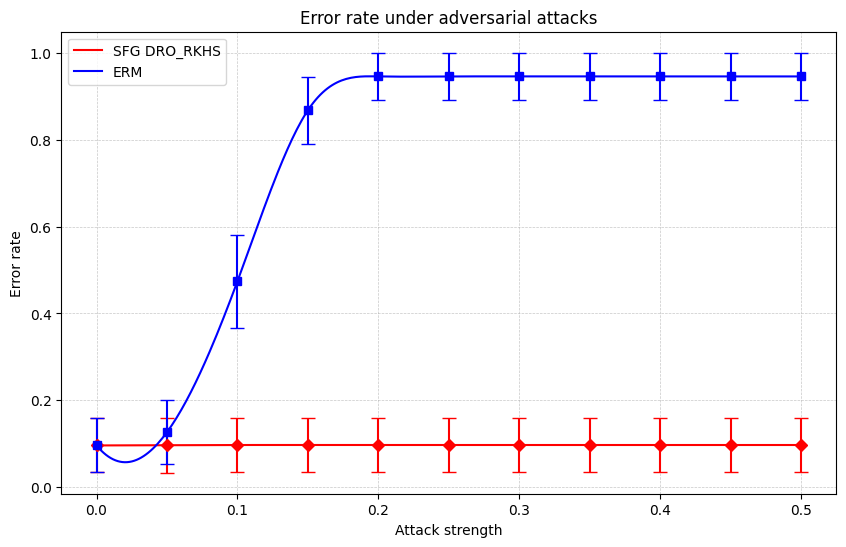

Error Rates under Adversarial Attacks:

Attack Strength	SFG DRO_RKHS	ERM	
--------------------------------------------------
0.00			0.0960		0.0960		
0.05			0.0965		0.1265		
0.10			0.0970		0.4740		
0.15			0.0970		0.8680		
0.20			0.0970		0.9460		
0.25			0.0970		0.9460		
0.30			0.0970		0.9460		
0.35			0.0970		0.9460		
0.40			0.0970		0.9460		
0.45			0.0970		0.9460		
0.50			0.0970		0.9460		


In [52]:
# Assuming that 'results_sfg' and 'results_erm' dictionaries are already defined and filled with your data

# Results for different models
results = [results_sfg_RKHS, results_erm]

# Corresponding labels for the legend
labels = ['SFG DRO_RKHS', 'ERM']

# Colors for the plot lines
colors = ['red', 'blue']

# Markers for the error bar
markers = ['D', 's']  # D is for diamond shape, s is for square shape

# Title for the plot
title = 'Error rate under adversarial attacks'

# Call the function to plot error rates
plot_error_rates(results, labels, colors, markers, title)
